In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pywr.uncertainties.uncertainty import uncertainty
from pywr.uncertainties.format import rounded_uncertainty_with_nominal_value
from pywr.uncertainties.devices import BRYMEN_BM811_CURRENT, BRYMEN_BM811_VOLTAGE
from typing import List
from tabulate import tabulate

In [2]:
COVERED_DATA_PATH = "data/cov.csv"

In [3]:
def compute_uncertainties(df: pd.DataFrame) -> pd.DataFrame:
    """Compute uncertainties for the given DataFrame.

    Args:
        df (pd.DataFrame): DataFrame with the data.

    Returns:
        pd.DataFrame: DataFrame with the data and uncertainties.
    """
    df["u(U)"] = df["U"].apply(
        lambda u: uncertainty(abs(u), 0.001, BRYMEN_BM811_VOLTAGE)
    )
    df["u(I)"] = df["I"].apply(
        lambda i: uncertainty(abs(i), 0.001, BRYMEN_BM811_CURRENT)
    )
    df["ln(I)"] = df["I"].apply(np.abs).apply(np.log)
    df["u(ln(I))"] = [
        abs(u_i / i) if i != 0 else 0 for i, u_i in zip(df["I"], df["u(I)"])
    ]

    return df

In [4]:
def format_sample_data(df: pd.DataFrame) -> pd.DataFrame:
    voltage_with_uncertainty = [
        rounded_uncertainty_with_nominal_value(u, uu)
        for u, uu in zip(df["U"], df["u(U)"])
    ]
    current_with_uncertainty = [
        rounded_uncertainty_with_nominal_value(i, ui)
        for i, ui in zip(df["I"], df["u(I)"])
    ]

    logarithm_with_uncertainty = [
        rounded_uncertainty_with_nominal_value(ln_i, u_ln_i)
        for ln_i, u_ln_i in zip(df["ln(I)"], df["u(ln(I))"])
    ]

    df["U"], df["u(U)"] = [u for u, _ in voltage_with_uncertainty], [
        uu for _, uu in voltage_with_uncertainty
    ]
    df["I"], df["u(I)"] = [i for i, _ in current_with_uncertainty], [
        ui for _, ui in current_with_uncertainty
    ]

    df["ln(I)"], df["u(ln(I))"] = [ln_i for ln_i, _ in logarithm_with_uncertainty], [
        u_ln_i for _, u_ln_i in logarithm_with_uncertainty
    ]

    df = df.reindex(columns=["U", "u(U)", "I", "u(I)", "ln(I)", "u(ln(I))"])

    return df

In [5]:
def linear_regression_rundown(model: sm.OLS) -> pd.DataFrame:
    a, ua = rounded_uncertainty_with_nominal_value(model.params[1], model.bse[1])
    b, ub = rounded_uncertainty_with_nominal_value(model.params[0], model.bse[0])
    return pd.DataFrame(
        {
            "a": [a],
            "u(a)": [ua],
            "b": [b],
            "u(b)": [ub],
            "R^2": [model.rsquared],
        }
    )

# Covered photodiode

## Sample data for covered photodiode

In [6]:
def predicate(row):
    return row["I"] > 0 and row["ln(I)"] > 0 and row["u(ln(I))"] < 0.1


df = pd.read_csv(COVERED_DATA_PATH, sep=";")
df = compute_uncertainties(df)
sample = df.loc[df.apply(predicate, axis=1)].sample(10)
sample = format_sample_data(sample)
sample.sort_values(by="U", inplace=True)
sample.reset_index(drop=True, inplace=True)
display(sample)

sample.to_csv("results/sample.csv")

,U,u(U),I,u(I),ln(I),u(ln(I))
0,636.0,1.4,3.380,0.027,1.2179,0.0080
1,660.0,1.4,4.537,0.028,1.5123,0.0062
2,683.0,1.4,5.853,0.030,1.7670,0.0051
3,738.0,1.4,10.573,0.035,2.3583,0.0033
4,757.0,1.4,12.833,0.038,2.5520,0.0030
5,778.0,1.4,15.882,0.041,2.7652,0.0026
6,863.0,1.5,33.902,0.062,3.5235,0.0018
7,896.0,1.5,43.253,0.073,3.7671,0.0017
8,912.0,1.5,48.291,0.079,3.8772,0.0016
9,919.0,1.5,50.300,0.081,3.9180,0.0016


## Voltage-current 

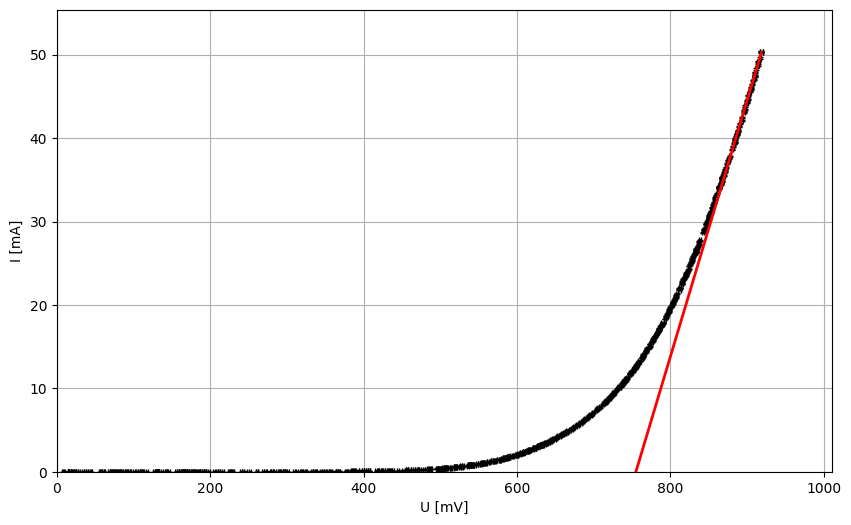

,a,u(a),b,u(b),R^2
0,0.3069,0.0021,-231.8,1.9,0.998647


+----+--------+--------+--------+--------+----------+
|    |      a |   u(a) |      b |   u(b) |      R^2 |
|----+--------+--------+--------+--------+----------|
|  0 | 0.3069 | 0.0021 | -231.8 |    1.9 | 0.998647 |
+----+--------+--------+--------+--------+----------+


In [7]:
df = pd.read_csv(COVERED_DATA_PATH, sep=";")
df = compute_uncertainties(df)

U_sample, I_sample = df["U"][-30:], df["I"][-30:]
model = sm.OLS(I_sample, sm.add_constant(U_sample)).fit()

X_pred = np.linspace(0, U_sample.max(), 10)
X_pred2 = sm.add_constant(X_pred)
y_pred = model.predict(X_pred2)


fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(0, 1.1 * U_sample.max())
ax.set_ylim(0, 1.1 * I_sample.max())

ax.errorbar(
    df["U"],
    df["I"],
    xerr=df["u(U)"],
    yerr=df["u(I)"],
    color="black",
    fmt=".",
    capsize=2,
    markersize=0,
)

plt.xlabel("U [mV]")
plt.ylabel("I [mA]")
plt.plot(X_pred, y_pred, "r-", linewidth=2)
ax.grid()
plt.show()

display(linear_regression_rundown(model))

print(tabulate(linear_regression_rundown(model), headers="keys", tablefmt="psql"))

## Logarithmic scale

50.3569984436035
919
706.1940185201823
dV =  212.80598147981766


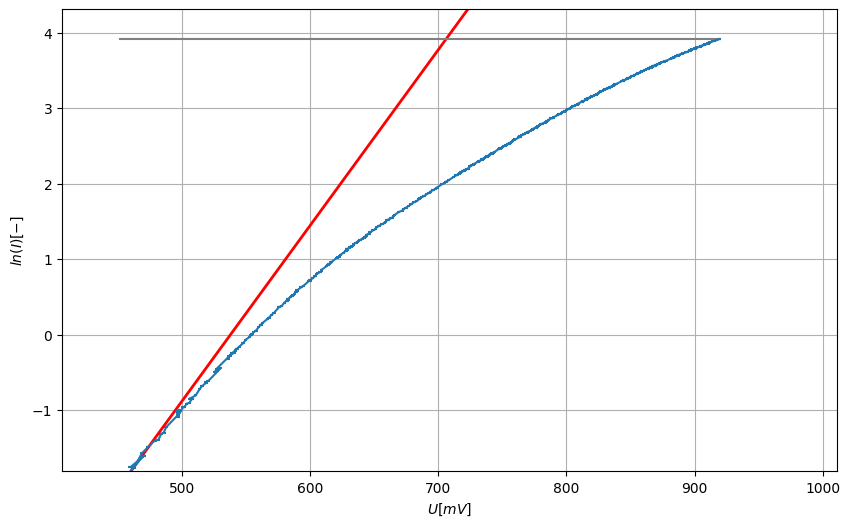

,a,u(a),b,u(b),R^2
0,0.0233,0.0014,-12.55,0.66,0.970564


+----+--------+--------+--------+--------+----------+
|    |      a |   u(a) |      b |   u(b) |      R^2 |
|----+--------+--------+--------+--------+----------|
|  0 | 0.0233 | 0.0014 | -12.55 |   0.66 | 0.970564 |
+----+--------+--------+--------+--------+----------+


In [8]:
def predicate(row):
    return row["U"] > 450


df = pd.read_csv(COVERED_DATA_PATH, sep=";")
df = df.loc[df.apply(predicate, axis=1)]
df = compute_uncertainties(df)


U_sample, I_sample = df["U"][0:10], df["ln(I)"][0:10]
model = sm.OLS(I_sample, sm.add_constant(U_sample)).fit()

X_pred = np.linspace(0, df["U"].max(), 200)
X_pred2 = sm.add_constant(X_pred)
y_pred = model.predict(X_pred2)

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(0.9 * df["U"].min(), 1.1 * df["U"].max())
ax.set_ylim(0.9 * df["ln(I)"].min(), 1.1 * df["ln(I)"].max())

ax.errorbar(df["U"], df["ln(I)"], xerr=df["u(U)"])
plt.plot(X_pred, y_pred, "r-", linewidth=2)

x_seq = np.linspace(df["U"].min(), df["U"].max(), 200)
y_seq = np.zeros_like(x_seq) + df["ln(I)"].max()
plt.plot(x_seq, y_seq, color="gray")


# ax + b = y -> x = (y - b) / a
print(df["I"].max())
print(df["U"].max())
print((df["ln(I)"].max() - model.params[0]) / model.params[1])
print("dV = ", df["U"].max() - (df["ln(I)"].max() - model.params[0]) / model.params[1])
# print(intersection)

ax.grid()
plt.xlabel("$U [mV]$")
plt.ylabel("$ln(I) [-]$")
plt.show()

display(linear_regression_rundown(model))
print(tabulate(linear_regression_rundown(model), headers="keys", tablefmt="psql"))

# Illuminated photodiode

In [9]:
ILLUMINATED_PHOTODIODES_DATAFRAMES = [
    pd.read_csv(path, delimiter=";")
    for path in [
        "data/7mA.csv",
        "data/13mA.csv",
        "data/19mA.csv",
        "data/25mA.csv",
        "data/31mA.csv",
        "data/38mA.csv",
    ]
]

ILLUMINATED_PHOTODIODES_LED_CURRENT = np.array(
    [7.245, 13.210, 19.221, 25.295, 31.327, 37.832]
)


def compute_short_circuit_currents() -> pd.DataFrame:
    shorting_currents = [
        df["I"][0:10].min() + 0.1 for df in ILLUMINATED_PHOTODIODES_DATAFRAMES
    ]
    return [
        df.iloc[(df["I"] - current).abs().idxmin()]
        for current, df in zip(shorting_currents, ILLUMINATED_PHOTODIODES_DATAFRAMES)
    ]


def voltage_predicate(df: pd.DataFrame) -> bool:
    return df["U"] > 400


def get_open_voltage() -> List[pd.DataFrame]:
    ur = [
        df.loc[df.apply(voltage_predicate, axis=1)]
        for df in ILLUMINATED_PHOTODIODES_DATAFRAMES
    ]
    return [df.loc[(df["I"]).abs().idxmin()] for df in ur]

3.0123180441630053


,a,u(a),b,u(b),R^2,R_S,u(R_S)
0,0.00654,0.00013,-2.784,0.047,0.998452,153.0,3.0


+----+---------+---------+--------+--------+----------+
|    |       a |    u(a) |      b |   u(b) |      R^2 |
|----+---------+---------+--------+--------+----------|
|  0 | 0.00654 | 0.00013 | -2.784 |  0.047 | 0.998452 |
+----+---------+---------+--------+--------+----------+


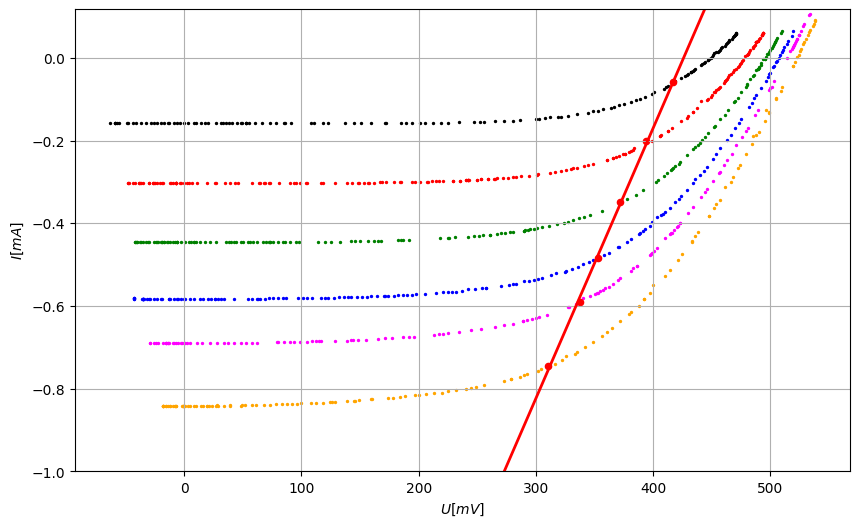

In [10]:
short_circuit_currents = compute_short_circuit_currents()

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_ylim(-1, 1.1 * max([df["I"].max() for df in ILLUMINATED_PHOTODIODES_DATAFRAMES]))

for df, color in zip(
    ILLUMINATED_PHOTODIODES_DATAFRAMES,
    ["black", "red", "green", "blue", "magenta", "orange"],
):
    plt.scatter(df["U"], df["I"], color=color, s=2)

for shorted_current in short_circuit_currents:
    plt.scatter(shorted_current["U"], shorted_current["I"], color="red", s=20)

plt.xlabel("$U [mV]$")
plt.ylabel("$I [mA]$")

currents = [df["I"] for df in short_circuit_currents]
voltages = [df["U"] for df in short_circuit_currents]
model = sm.OLS(currents, sm.add_constant(voltages)).fit()
X_pred = np.linspace(0, max(voltages) + 100, 10)
X_pred2 = sm.add_constant(X_pred)
y_pred = model.predict(X_pred2)

plt.plot(X_pred, y_pred, "r-", linewidth=2)

plt.grid()

rundown = linear_regression_rundown(model)
print(model.bse[1] / (model.params[1] ** 2))
static_resistance, static_resistance_uncertainty = rounded_uncertainty_with_nominal_value(1 / model.params[1], model.bse[1] / (model.params[1] ** 2))

rundown["R_S"] = [static_resistance]
rundown["u(R_S)"] = [static_resistance_uncertainty]

display(rundown)
rundown.to_csv("results/family_results.csv")
print(tabulate(linear_regression_rundown(model), headers="keys", tablefmt="psql"))

#### $I_{Z} = f(I_{LED})$ characteristic

,a,u(a),b,u(b),R^2
0,-0.02217,0.00052,0.091,0.013,0.997833


+----+----------+---------+-------+--------+----------+
|    |        a |    u(a) |     b |   u(b) |      R^2 |
|----+----------+---------+-------+--------+----------|
|  0 | -0.02217 | 0.00052 | 0.091 |  0.013 | 0.997833 |
+----+----------+---------+-------+--------+----------+


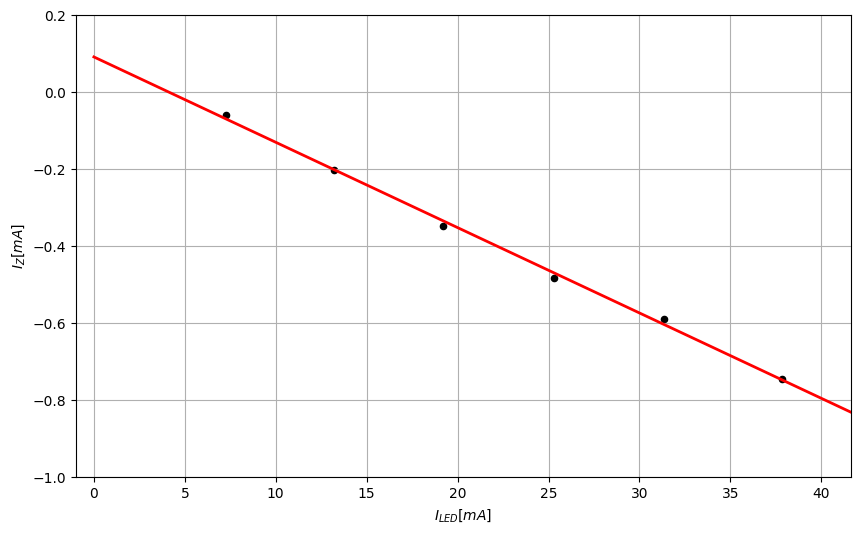

In [11]:
short_circuit_currents = compute_short_circuit_currents()

shorting_currents = [df["I"] for df in short_circuit_currents]
model = sm.OLS(
    shorting_currents, sm.add_constant(ILLUMINATED_PHOTODIODES_LED_CURRENT)
).fit()
X_pred = np.linspace(0, max(ILLUMINATED_PHOTODIODES_LED_CURRENT) + 100, 10)
X_pred2 = sm.add_constant(X_pred)
y_pred = model.predict(X_pred2)

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(-1, 1.1 * max(ILLUMINATED_PHOTODIODES_LED_CURRENT))
ax.set_ylim(-1, 0.2)

for shorting_current, led_current in zip(
    short_circuit_currents, ILLUMINATED_PHOTODIODES_LED_CURRENT
):
    ax.scatter(led_current, shorting_current["I"], color="black", s=20)

ax.plot(X_pred, y_pred, "r-", linewidth=2)
plt.ylabel("$I_Z [mA]$")
plt.xlabel("$I_{LED} [mA]$")
ax.grid()


rundown = linear_regression_rundown(model)
rundown.to_csv("results/shorting_currents_from_led_current.csv")

display(linear_regression_rundown(model))
print(tabulate(linear_regression_rundown(model), headers="keys", tablefmt="psql"))

#### $U_{R} = f(I_{LED})$ characteristic

,a,u(a),b,u(b),R^2
0,44.66,0.97,361.5,2.9,0.998127


+----+-------+--------+-------+--------+----------+
|    |     a |   u(a) |     b |   u(b) |      R^2 |
|----+-------+--------+-------+--------+----------|
|  0 | 44.66 |   0.97 | 361.5 |    2.9 | 0.998127 |
+----+-------+--------+-------+--------+----------+


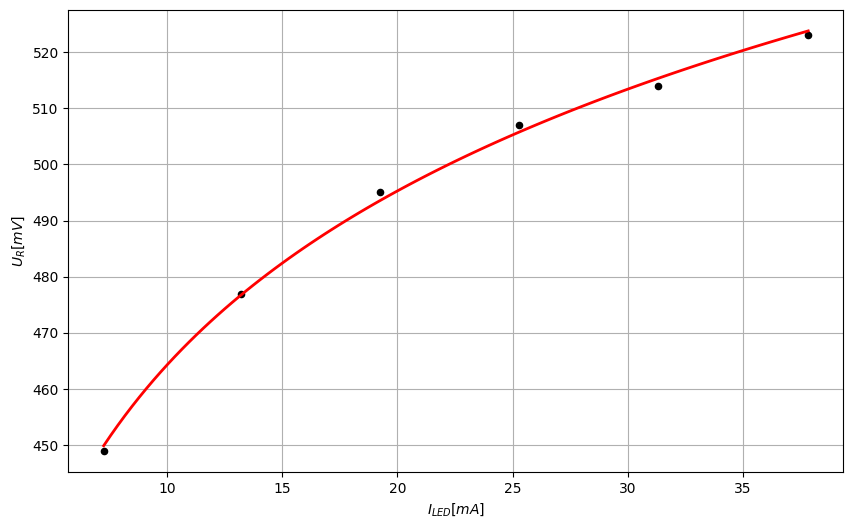

In [12]:
def log_func(x, a, b):
    return a * np.log(x) + b


ur = get_open_voltage()

# currents = [df["I"] for df in ur]
voltages = [df["U"] for df in ur]
arr = np.polyfit(np.log(ILLUMINATED_PHOTODIODES_LED_CURRENT), voltages, 1)
# a, b = arr

model = sm.OLS(
    voltages, sm.add_constant(np.log(ILLUMINATED_PHOTODIODES_LED_CURRENT))
).fit()


# model.summary()
b, a = model.params

fig, ax = plt.subplots(figsize=(10, 6))

x = np.linspace(
    ILLUMINATED_PHOTODIODES_LED_CURRENT[0], ILLUMINATED_PHOTODIODES_LED_CURRENT[-1], 100
)
y = a * np.log(x) + b

ax.plot(x, y, "r-", linewidth=2)


for df, iled in zip(ur, ILLUMINATED_PHOTODIODES_LED_CURRENT):
    ax.scatter(iled, df["U"], color="black", s=20)
ax.grid()

plt.ylabel("$U_R [mV]$")
plt.xlabel("$I_{LED} [mA]$")

rundown = linear_regression_rundown(model)
rundown.to_csv("results/open_voltage_from_led_current.csv")

display(linear_regression_rundown(model))
print(tabulate(linear_regression_rundown(model), headers="keys", tablefmt="psql"))

In [13]:
short_circuit_currents = compute_short_circuit_currents()
open_voltage = get_open_voltage()


df = pd.DataFrame(
    {
        "I_LED": ILLUMINATED_PHOTODIODES_LED_CURRENT,
        "u(I_LED)": [
            uncertainty(abs(i), 0.001, BRYMEN_BM811_CURRENT)
            for i in ILLUMINATED_PHOTODIODES_LED_CURRENT
        ],
        "I_Z": [df["I"] for df in short_circuit_currents],
        "u(I_Z)": [
            uncertainty(abs(df["I"]), 0.001, BRYMEN_BM811_CURRENT)
            for df in short_circuit_currents
        ],
        "U_R": [df["U"] for df in open_voltage],
        "u(U_R)": [
            uncertainty(abs(df["U"]), 0.001, BRYMEN_BM811_VOLTAGE)
            for df in open_voltage
        ],
    }
)


voltage_with_uncertainty = [
    rounded_uncertainty_with_nominal_value(u, uu)
    for u, uu in zip(df["U_R"], df["u(U_R)"])
]
led_current_with_uncertainty = [
    rounded_uncertainty_with_nominal_value(i, ui)
    for i, ui in zip(df["I_LED"], df["u(I_LED)"])
]
shorting_current_with_uncertainty = [
    rounded_uncertainty_with_nominal_value(i, ui)
    for i, ui in zip(df["I_Z"], df["u(I_Z)"])
]

df["U_R"], df["u(U_R)"] = [u for u, _ in voltage_with_uncertainty], [
    uu for _, uu in voltage_with_uncertainty
]
df["I_LED"], df["u(I_LED)"] = [i for i, _ in led_current_with_uncertainty], [
    ui for _, ui in led_current_with_uncertainty
]

df["I_Z"], df["u(I_Z)"] = [i for i, _ in shorting_current_with_uncertainty], [
    ui for _, ui in shorting_current_with_uncertainty
]

display(df)
print(tabulate(df, headers="keys", tablefmt="psql"))

,I_LED,u(I_LED),I_Z,u(I_Z),U_R,u(U_R)
0,7.245,0.031,-0.059,0.023,449.0,1.5
1,13.210,0.038,-0.202,0.023,477.0,1.5
2,19.221,0.045,-0.348,0.023,495.0,1.5
3,25.295,0.052,-0.484,0.024,507.0,1.3
4,31.327,0.059,-0.590,0.024,514.0,1.3
5,37.832,0.067,-0.745,0.024,523.0,1.3


+----+---------+------------+--------+----------+-------+----------+
|    |   I_LED |   u(I_LED) |    I_Z |   u(I_Z) |   U_R |   u(U_R) |
|----+---------+------------+--------+----------+-------+----------|
|  0 |   7.245 |      0.031 | -0.059 |    0.023 |   449 |      1.5 |
|  1 |  13.21  |      0.038 | -0.202 |    0.023 |   477 |      1.5 |
|  2 |  19.221 |      0.045 | -0.348 |    0.023 |   495 |      1.5 |
|  3 |  25.295 |      0.052 | -0.484 |    0.024 |   507 |      1.3 |
|  4 |  31.327 |      0.059 | -0.59  |    0.024 |   514 |      1.3 |
|  5 |  37.832 |      0.067 | -0.745 |    0.024 |   523 |      1.3 |
+----+---------+------------+--------+----------+-------+----------+


## Distance -- short-circuit current characteristic

,d,I,u(1/d^2),u(I),1/d^2
0,16,-17.81,0.000141,0.023115,0.003906
1,18,-14.28,0.000099,0.023110,0.003086
2,20,-11.62,0.000072,0.023107,0.002500
3,22,-9.79,0.000054,0.023105,0.002066
4,24,-8.43,0.000042,0.023104,0.001736
5,26,-7.11,0.000033,0.023102,0.001479
6,28,-6.16,0.000026,0.023101,0.001276


+----+-----+--------+-------------+-----------+------------+
|    |   d |      I |    u(1/d^2) |      u(I) |      1/d^2 |
|----+-----+--------+-------------+-----------+------------|
|  0 |  16 | -17.81 | 0.000140955 | 0.0231146 | 0.00390625 |
|  1 |  18 | -14.28 | 9.8997e-05  | 0.0231105 | 0.00308642 |
|  2 |  20 | -11.62 | 7.21688e-05 | 0.0231074 | 0.0025     |
|  3 |  22 |  -9.79 | 5.42215e-05 | 0.0231053 | 0.00206612 |
|  4 |  24 |  -8.43 | 4.17643e-05 | 0.0231037 | 0.00173611 |
|  5 |  26 |  -7.11 | 3.28488e-05 | 0.0231022 | 0.00147929 |
|  6 |  28 |  -6.16 | 2.63006e-05 | 0.0231011 | 0.00127551 |
+----+-----+--------+-------------+-----------+------------+
+----+-------+--------+--------+--------+----------+
|    |     a |   u(a) |      b |   u(b) |      R^2 |
|----+-------+--------+--------+--------+----------|
|  0 | -4408 |     38 | -0.636 |  0.094 | 0.999626 |
+----+-------+--------+--------+--------+----------+


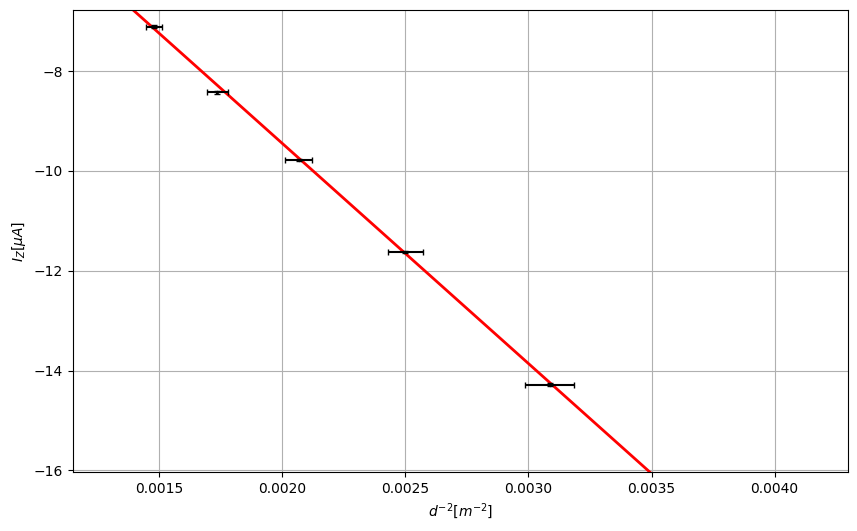

In [14]:
df = pd.read_csv("data/distance.csv")

df["u(1/d^2)"] = df["d"].apply(lambda x: (2 / (x**3)) * (0.5 / np.sqrt(3)))
df["u(I)"] = df["I"].apply(
    lambda i: uncertainty(abs(i / 1000), 0.001, BRYMEN_BM811_CURRENT)
)
df["1/d^2"] = df["d"].apply(lambda x: 1 / x**2)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df["1/d^2"], df["I"], color="black", s=2)

model = sm.OLS(df["I"], sm.add_constant(df["1/d^2"])).fit()
X_pred = np.linspace(0, max(df["1/d^2"]) + 100, 10)
X_pred2 = sm.add_constant(X_pred)
y_pred = model.predict(X_pred2)

ax.set_xlim(0.9 * min(df["1/d^2"]), 1.1 * max(df["1/d^2"]))
ax.set_ylim(0.9 * min(df["I"]), 1.1 * max(df["I"]))

ax.plot(X_pred, y_pred, "r-", linewidth=2)

ax.errorbar(
    df["1/d^2"],
    df["I"],
    xerr=df["u(1/d^2)"],
    yerr=df["u(I)"],
    color="black",
    fmt=".",
    capsize=2,
    markersize=0,
)
ax.grid()

plt.ylabel("$I_Z [\mu A]$")
plt.xlabel("$d^{-2} [m^{-2}]$")

rundown = linear_regression_rundown(model)
rundown.to_csv("results/short_circuit_current_from_distance.csv")

display(df)
print(tabulate(df, headers="keys", tablefmt="psql"))
print(tabulate(linear_regression_rundown(model), headers="keys", tablefmt="psql"))